In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import ast
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
papers = pd.read_csv('paperabstracts.csv')
papers.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"
4,Towards to Robust and Generalized Medical Imag...,"To mitigate the radiologist's workload, comput...","['cs.CV', 'cs.AI']"


In [3]:
print(papers.shape)

(8355, 3)


In [4]:
description_category = papers[['terms','summaries','titles']]
description_category['terms'] = description_category['terms'].apply(lambda x: ast.literal_eval(x))
description_category.head()

,terms,summaries,titles
0,"[cs.CV, cs.LG]",Stereo matching is one of the widely used tech...,Survey on Semantic Stereo Matching / Semantic ...
1,"[cs.CV, cs.AI, cs.LG]",The recent advancements in artificial intellig...,FUTURE-AI: Guiding Principles and Consensus Re...
2,"[cs.CV, cs.AI]","In this paper, we proposed a novel mutual cons...",Enforcing Mutual Consistency of Hard Regions f...
3,"[cs.CV, cs.LG]","To ensure safety in automated driving, the cor...",Background-Foreground Segmentation for Interio...
4,"[cs.CV, cs.AI]","To mitigate the radiologist's workload, comput...",Towards to Robust and Generalized Medical Imag...


In [5]:
columns = ['category_1', 'category_2', 'category_3',
          'category_4', 'category_5']
cat = pd.DataFrame(description_category['terms'].to_list(), columns = columns)
cat

,category_1,category_2,category_3,category_4,category_5
0,cs.CV,cs.LG,None,None,None
1,cs.CV,cs.AI,cs.LG,None,None
2,cs.CV,cs.AI,None,None,None
3,cs.CV,cs.LG,None,None,None
4,cs.CV,cs.AI,None,None,None
...,...,...,...,...,...
8350,cs.LG,cs.AI,cs.NE,None,None
8351,cs.LG,cs.CV,cs.NE,None,None
8352,cs.LG,cs.CL,None,None,None
8353,cs.LG,cs.CV,cs.NE,None,None


In [6]:
cat.isnull().values.any()

True

In [7]:
category_1_genres = cat.category_1.unique()
category_2_genres = cat.category_2.unique()
category_3_genres = cat.category_3.unique()
category_4_genres = cat.category_4.unique()
category_5_genres = cat.category_5.unique()



genres = np.concatenate([category_1_genres, category_2_genres, category_3_genres,
                         category_4_genres, category_5_genres
                        ])
genres = list(dict.fromkeys(genres))
genres = [x for x in genres if x is not None]

cat = pd.concat([cat,pd.DataFrame(columns = list(genres))])
cat.fillna(0, inplace = True)
genres

['cs.CV', 'cs.LG', 'cs.CL', 'cs.AI', 'cs.NE', 'cs.RO']

In [8]:
row = 0
for genre in cat['category_1']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1
    
row = 0
for genre in cat['category_2']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1
    
row = 0
for genre in cat['category_3']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1
    
row = 0
for genre in cat['category_4']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1
    
row = 0
for genre in cat['category_5']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1

In [9]:
description_category_new = pd.concat([description_category['titles'],description_category['summaries'],  
                                     cat.loc[:,"cs.CV":]],
                                    axis=1)
description_category_new.head()

,titles,summaries,cs.CV,cs.LG,cs.CL,cs.AI,cs.NE,cs.RO
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,1,1,0,0,0,0
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,1,1,0,1,0,0
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...",1,0,0,1,0,0
3,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...",1,1,0,0,0,0
4,Towards to Robust and Generalized Medical Imag...,"To mitigate the radiologist's workload, comput...",1,0,0,1,0,0


In [10]:
bar_plot = pd.DataFrame()
bar_plot['cat'] = description_category_new.columns[2:]
bar_plot['count'] = description_category_new.iloc[:,2:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head(6)

,cat,count
0,cs.CV,5835
1,cs.LG,4831
2,cs.AI,1989
3,cs.RO,1820
4,cs.CL,1427
5,cs.NE,1219


In [11]:
cols = description_category_new.columns
cols = list(description_category_new.columns)
mesh_Heading_categories = cols[2:]
num_labels = len(mesh_Heading_categories)
print('Labels Class: "\n"',mesh_Heading_categories)
print("\n")
print('Number of Labels: ' ,num_labels)

Labels Class: "
" ['cs.CV', 'cs.LG', 'cs.CL', 'cs.AI', 'cs.NE', 'cs.RO']


Number of Labels:  6


C:\Users\Agus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


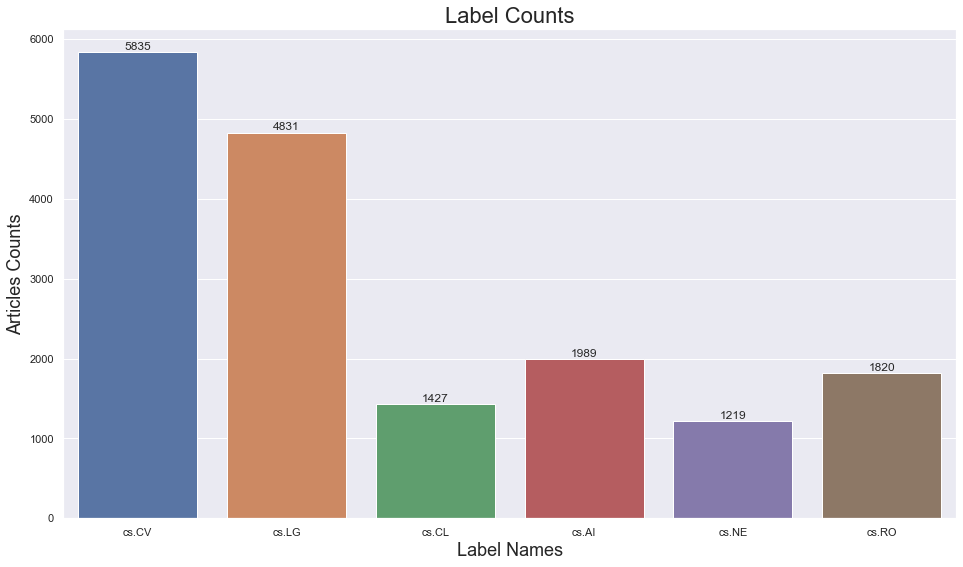

In [12]:
sns.set(font_scale = 1)
plt.figure(figsize=(16,9))
ax= sns.barplot(mesh_Heading_categories, description_category_new.iloc[:,2:].sum().values)
plt.title('Label Counts', fontsize=22)
plt.ylabel('Articles Counts', fontsize=18)
plt.xlabel('Label Names', fontsize=18)

#adding the text labels
rects = ax.patches
labels = description_category_new.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)

plt.show()

In [13]:
def decontract(sentence):
    # specific
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)

    # general
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

def cleanPunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub("", sentence)

In [14]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

re_stop_words = re.compile(r"\b(" + "|".join(stopwords) + ")\\W", re.I)

In [15]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [16]:
description_category_new.head()

,titles,summaries,cs.CV,cs.LG,cs.CL,cs.AI,cs.NE,cs.RO
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,1,1,0,0,0,0
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,1,1,0,1,0,0
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...",1,0,0,1,0,0
3,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...",1,1,0,0,0,0
4,Towards to Robust and Generalized Medical Imag...,"To mitigate the radiologist's workload, comput...",1,0,0,1,0,0


In [17]:
description_category_new['summaries'] = description_category_new['summaries'].str.lower()
description_category_new['summaries'] = description_category_new['summaries'].apply(decontract)
description_category_new['summaries'] = description_category_new['summaries'].apply(cleanPunc)
description_category_new['summaries'] = description_category_new['summaries'].apply(keepAlpha)
description_category_new['summaries'] = description_category_new['summaries'].apply(removeStopWords)
description_category_new['summaries'] = description_category_new['summaries'].apply(stemming)

In [18]:
description_category_new.head()

,titles,summaries,cs.CV,cs.LG,cs.CL,cs.AI,cs.NE,cs.RO
0,Survey on Semantic Stereo Matching / Semantic ...,stereo match one wide use techniqu infer depth...,1,1,0,0,0,0
1,FUTURE-AI: Guiding Principles and Consensus Re...,recent advanc artifici intellig ai combin exte...,1,1,0,1,0,0
2,Enforcing Mutual Consistency of Hard Regions f...,paper propos novel mutual consist network mcne...,1,0,0,1,0,0
3,Background-Foreground Segmentation for Interio...,ensur safeti autom drive correct percept situa...,1,1,0,0,0,0
4,Towards to Robust and Generalized Medical Imag...,mitig radiologist workload computeraid diagnos...,1,0,0,1,0,0


In [19]:
text = papers["summaries"].tolist()
print(len(text))

8355


In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
token =Tokenizer()
token.fit_on_texts(text)
r =token.index_word
print (token.index_word)

C:\Users\Agus\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


{1: 'the', 2: 'of', 3: 'and', 4: 'to', 5: 'a', 6: 'in', 7: 'we', 8: 'for', 9: 'is', 10: 'on', 11: 'that', 12: 'this', 13: 'with', 14: 'learning', 15: 'as', 16: 'our', 17: 'by', 18: 'are', 19: 'an', 20: 'from', 21: 'image', 22: 'model', 23: 'data', 24: 'based', 25: 'can', 26: 'which', 27: 'object', 28: 'be', 29: 'network', 30: 'detection', 31: 'method', 32: 'propose', 33: 'methods', 34: 'performance', 35: 'models', 36: 'training', 37: 'images', 38: 'using', 39: 'state', 40: 'tasks', 41: 'proposed', 42: 'deep', 43: 'it', 44: 'paper', 45: 'neural', 46: 'results', 47: 'show', 48: 'such', 49: 'approach', 50: 'task', 51: 'networks', 52: 'art', 53: 'or', 54: 'information', 55: 'have', 56: 'dataset', 57: 'different', 58: 'at', 59: 'these', 60: 'two', 61: 'features', 62: 'has', 63: 'attention', 64: 'segmentation', 65: 'representation', 66: 'time', 67: 'also', 68: 'datasets', 69: 'more', 70: 'new', 71: 'novel', 72: 'both', 73: '3d', 74: 'visual', 75: 'problem', 76: 'real', 77: 'work', 78: 'not',

In [21]:
encode_text = token.texts_to_sequences(text)
encode_text

[[795,
  457,
  9,
  104,
  2,
  1,
  489,
  85,
  205,
  8,
  2291,
  124,
  20,
  795,
  37,
  2740,
  4,
  111,
  409,
  3,
  465,
  43,
  62,
  725,
  104,
  2,
  1,
  815,
  2339,
  2,
  201,
  490,
  43,
  2741,
  111,
  158,
  6,
  242,
  241,
  622,
  499,
  73,
  637,
  3,
  137,
  119,
  1149,
  1133,
  322,
  1749,
  6,
  224,
  3927,
  1498,
  3,
  6853,
  845,
  9,
  1,
  815,
  315,
  6,
  795,
  457,
  142,
  2467,
  55,
  357,
  11,
  112,
  912,
  20,
  21,
  64,
  25,
  28,
  85,
  4,
  173,
  1,
  46,
  2,
  795,
  457,
  137,
  42,
  45,
  29,
  239,
  55,
  102,
  41,
  4,
  623,
  1,
  936,
  2,
  112,
  64,
  6,
  795,
  457,
  12,
  44,
  597,
  4,
  1448,
  5,
  691,
  408,
  1,
  39,
  2,
  52,
  51,
  72,
  6,
  321,
  2,
  92,
  3,
  6,
  321,
  2,
  465,
  26,
  18,
  2,
  398,
  804,
  6,
  76,
  66,
  158],
 [1,
  142,
  2766,
  6,
  818,
  1247,
  1014,
  866,
  13,
  1,
  214,
  630,
  2,
  23,
  275,
  17,
  4314,
  1380,
  197,
  62,
  1995,
  4,
  1,

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_kata=50
x= pad_sequences(encode_text, maxlen = max_kata, padding="post")
x

array([[  137,    42,    45, ...,    76,    66,   158],
       [  812,  1269,  2578, ...,    96,  1380,  1005],
       [    1,  3846,   573, ...,   420,    21,    64],
       ...,
       [ 6669,  2472,   128, ...,     1,    52,   118],
       [  121,     2,   367, ...,     2,  2643,   216],
       [  199,    54,   684, ...,     1, 25054,   183]])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    description_category_new[description_category_new.columns[2:]], 
                                                    test_size=0.2)

In [24]:
def print_shapes(X_train, X_test, Y_train, Y_test):
    print(f"X_train: {X_train.shape}\n"\
          f"X_test: {X_test.shape}\n"\
          f"y_train: {y_train.shape}\n"\
          f"y_test: {y_test.shape}\n")
    
print_shapes(X_train, X_test, y_train, y_test)

X_train: (6684, 50)
X_test: (1671, 50)
y_train: (6684, 6)
y_test: (1671, 6)



In [25]:
labels = description_category_new[["cs.CV", "cs.LG", "cs.CL", "cs.AI", "cs.NE", "cs.RO"]]

In [26]:
# set the dependant and independant variables 
X = list(description_category_new['summaries']) # list of all plots
y = labels.values # 2D array with one hot encoded genres for each plot

In [27]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
print("Length of X_train =",len(X_train))
print("Length of X_test=",len(X_test))

Length of X_train = 6684
Length of X_test= 1671


In [29]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [30]:
# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=5,
                 min_count=8)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 4253


In [31]:
 # Defining the model input length.
input_length = 200

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [32]:
vocab_length = 5000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 5000


In [33]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (6684, 200)
X_test.shape : (1671, 200)


In [34]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (5000, 100)


In [35]:
from keras.layers import Flatten
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, LSTM
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [36]:
model = Sequential()
deep_inputs = Input(shape=(input_length,))
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(32)(embedding_layer)
dropout_layer = Dropout(0.8)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

In [37]:
print(model.summary()) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          500000    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 517,222
Trainable params: 17,222
Non-trainable params: 500,000
_________________________________________________________________
None


In [38]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=12, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-6, patience=12),
            ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)]

In [39]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=20,
    validation_split=0.2,
    callbacks=callbacks)

Epoch 1/20
42/42 [==============================] - 19s 308ms/step - loss: 0.5680 - accuracy: 0.6129 - val_loss: 0.5002 - val_accuracy: 0.7472 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - 11s 262ms/step - loss: 0.4530 - accuracy: 0.8068 - val_loss: 0.4312 - val_accuracy: 0.7981 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - 10s 246ms/step - loss: 0.4154 - accuracy: 0.8392 - val_loss: 0.4081 - val_accuracy: 0.8414 - lr: 0.0010
Epoch 4/20
42/42 [==============================] - 15s 349ms/step - loss: 0.3887 - accuracy: 0.8483 - val_loss: 0.3941 - val_accuracy: 0.8414 - lr: 0.0010
Epoch 5/20
42/42 [==============================] - 11s 268ms/step - loss: 0.3658 - accuracy: 0.8612 - val_loss: 0.3708 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 6/20
42/42 [==============================] - 10s 242ms/step - loss: 0.3496 - accuracy: 0.8627 - val_loss: 0.3605 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 7/20
42/42 [==============================] - 12s 287ms/st

In [41]:
lstm_model = model
metrics = lstm_model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

53/53 [==============================] - 2s 43ms/step - loss: 0.3320 - accuracy: 0.8528
accuracy: 0.8527827858924866


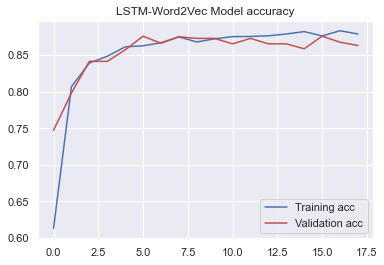

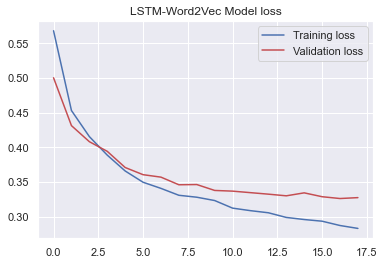

In [42]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('LSTM-Word2Vec Model accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('LSTM-Word2Vec Model loss')
plt.legend()

plt.show()

In [43]:
#train
LSTM_Word2Vec_train_score = model.evaluate(X_train, y_train)
print('Train Loss:', LSTM_Word2Vec_train_score[0])
print('Train Accuracy:', LSTM_Word2Vec_train_score[1])

#test
LSTM_Word2Vec_test_score = model.evaluate(X_test, y_test)
print('Test Loss:', LSTM_Word2Vec_test_score[0])
print('Test Accuracy:', LSTM_Word2Vec_test_score[1])


209/209 [==============================] - 10s 49ms/step - loss: 0.2874 - accuracy: 0.8766
Train Loss: 0.2874428629875183
Train Accuracy: 0.8765709400177002
53/53 [==============================] - 2s 41ms/step - loss: 0.3320 - accuracy: 0.8528
Test Loss: 0.33203592896461487
Test Accuracy: 0.8527827858924866


In [44]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names = ['cs.CV', 'cs.LG', 'cs.CL', 'cs.AI', 'cs.NE', 'cs.RO']))

              precision    recall  f1-score   support

       cs.CV       0.95      0.90      0.92      1180
       cs.LG       0.84      0.80      0.82       977
       cs.CL       0.80      0.77      0.79       276
       cs.AI       0.55      0.27      0.36       399
       cs.NE       0.63      0.26      0.37       252
       cs.RO       0.72      0.71      0.72       344

   micro avg       0.84      0.72      0.77      3428
   macro avg       0.75      0.62      0.66      3428
weighted avg       0.81      0.72      0.76      3428
 samples avg       0.87      0.77      0.79      3428



In [45]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, y_pred)

array([[[ 441,   50],
        [ 122, 1058]],

       [[ 541,  153],
        [ 197,  780]],

       [[1342,   53],
        [  63,  213]],

       [[1186,   86],
        [ 292,  107]],

       [[1380,   39],
        [ 186,   66]],

       [[1232,   95],
        [  99,  245]]], dtype=int64)

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score
lstm_model = model
pred = model.predict(X_test)
pred = np.argmax(pred, 1)
true = np.argmax (np.asarray(y_test), 1)
print(roc_auc_score(true, pred))

0.8793028754875901


In [47]:
random_probs = [0 for _ in range(len(y_test))]
random_auc = roc_auc_score(true, random_probs)
lstm_auc = roc_auc_score(true, pred)

In [48]:
print('LSTM : AUCROC = %.3f' % (lstm_auc))

LSTM : AUCROC = 0.879


In [49]:
random_fpr, random_tpr, _ = roc_curve(true, random_probs)
lstm_fpr, lstm_tpr, _ = roc_curve(true, pred)

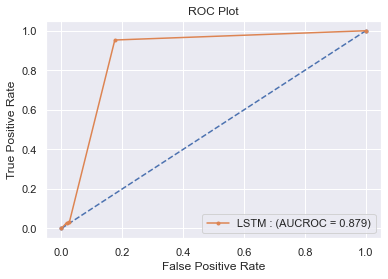

In [50]:
plt.plot(random_fpr, random_tpr, marker='.', linestyle="--")
plt.plot(lstm_fpr, lstm_tpr, marker='.', label='LSTM : (AUCROC = %.3f)' % lstm_auc)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()